# Análisis de Series Temporales
## Trabajo Práctico Nro. 2

Estudiante: Esp. Ing. Mariano Martín Gualpa (mgualpa@gmail.com)

In [0]:
#!wget -P x13asall/ -c https://www.census.gov/ts/x13as/unix/x13asall_V1.1_B39.tar.gz
#!tar -C x13asall/ -xvf x13asall/x13asall_V1.1_B39.tar.gz
#!mv x13asall/x13as .
#!mkdir datasets
#!mv demanda.csv datasets/
#!mv Telefonia_movil.csv datasets/
#!pip install statsmodels --upgrade

#!pip show statsmodels

# 1. Consigna

1. Levantar los datos desde el archivo dataset/demanda.csv. Los mismos fueron extraídos de http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx 

2. Explorar los datos y visualizar descomposición de datos

3. Modelar con Holt Winters Smoothing con diferentes parámetros

4. Visualizar los resultados y evaluar su poder predictivo, comparando ambos modelos


# 2. Desarrollo

## 2.1. Carga y Limpieza de Datos

Correspondiente al punto 1: Levantar los datos desde el archivo dataset/demanda.csv. Los mismos fueron extraídos de http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx

In [0]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [0]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [0]:
plt.rcParams['figure.figsize'] = [15, 10]

In [5]:
data=pd.read_csv('datasets/demanda.csv', index_col='TIPO', parse_dates=True, dayfirst=True)

data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2018-04-01,4.084.110,3.131.427,3.277.777,10.493.315
2018-05-01,4.276.830,3.101.854,3.286.778,10.665.462
2018-06-01,5.569.775,3.231.036,3.123.287,11.924.098
2018-07-01,6.167.114,3.326.186,3.112.541,12.605.842
2018-08-01,5.359.054,3.237.765,3.112.882,11.709.701


In [6]:
data.isnull().sum(axis = 0)

Residencial                    0
Comercial                      0
Industrial/Comercial Grande    0
TOTAL                          0
dtype: int64

In [7]:
if (data["Residencial"].dtype != int):
    data["Residencial"] = data["Residencial"].str.replace(".","").astype(int)

if (data["Comercial"].dtype != int):
    data["Comercial"] = data["Comercial"].str.replace(".","").astype(int)

if (data["Industrial/Comercial Grande"].dtype != int):
    data["Industrial/Comercial Grande"] = data["Industrial/Comercial Grande"].str.replace(".","").astype(int)

if (data["TOTAL"].dtype != int):
    data["TOTAL"] = data["TOTAL"].str.replace(".","").astype(int)

data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2018-04-01,4084110,3131427,3277777,10493315
2018-05-01,4276830,3101854,3286778,10665462
2018-06-01,5569775,3231036,3123287,11924098
2018-07-01,6167114,3326186,3112541,12605842
2018-08-01,5359054,3237765,3112882,11709701


In [8]:
data.dtypes

Residencial                    int64
Comercial                      int64
Industrial/Comercial Grande    int64
TOTAL                          int64
dtype: object

In [9]:
data.index.names = ['Período']
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
Período,,,,
2018-04-01,4084110,3131427,3277777,10493315
2018-05-01,4276830,3101854,3286778,10665462
2018-06-01,5569775,3231036,3123287,11924098
2018-07-01,6167114,3326186,3112541,12605842
2018-08-01,5359054,3237765,3112882,11709701


## 2.2 Visualización de Datos
Correspondiente al punto 2: Explorar los datos y visualizar descomposición de datos

### 2.2.1. Exploración de los datos


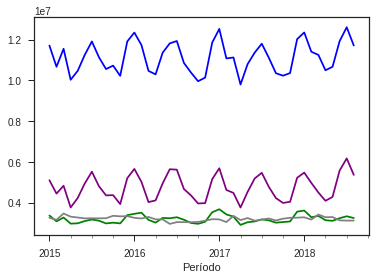

In [10]:
data[:]['Residencial'].plot(color='purple',figsize=(6,4));
data[:]['Comercial'].plot(color='green',figsize=(6,4));
data[:]['Industrial/Comercial Grande'].plot(color='gray',figsize=(6,4));
data[:]['TOTAL'].plot(color='blue',figsize=(6,4));


Selección de la serie a utilizar.

In [0]:
def create_ts(data, columnName):
    y = data[columnName].copy()
    #y.index = y.index.to_period(freq='M')
    ts = data[columnName]
    return ts

ts = create_ts(data, 'TOTAL')

### 2.2.2. Visualización de la Descomposición.

#### IMPORTANTE: 

DEBE CONFIGURAR LA VARIABLE X13_PATH CON LA RUTA AL DIRECTORIO DONDE ESTE INSTALADO X13.



In [0]:
import os

X13_PATH = "."  # Hay una copia del .exe en la carpeta del TP. 
                # Si se ejecuta en linux asegurarse de indicar 
                # el path correcto o que no exista conflicto de 
                # nombres entre los archivos. 

decomposition = sm.tsa.x13_arima_analysis(ts,x12path=X13_PATH)

In [13]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

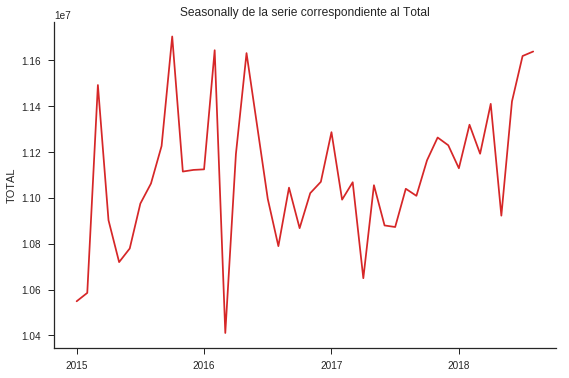

In [14]:
fig, ax= plt.subplots(figsize=(9,6))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('TOTAL')
ax.set_title('Seasonally de la serie correspondiente al Total')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

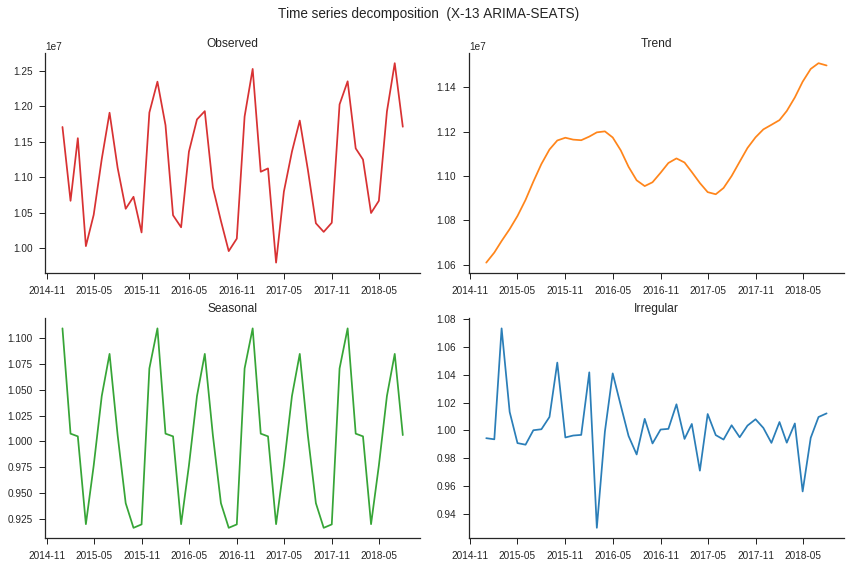

In [15]:
import plotting
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

#### Otro modelo de descompocisión.

In [0]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

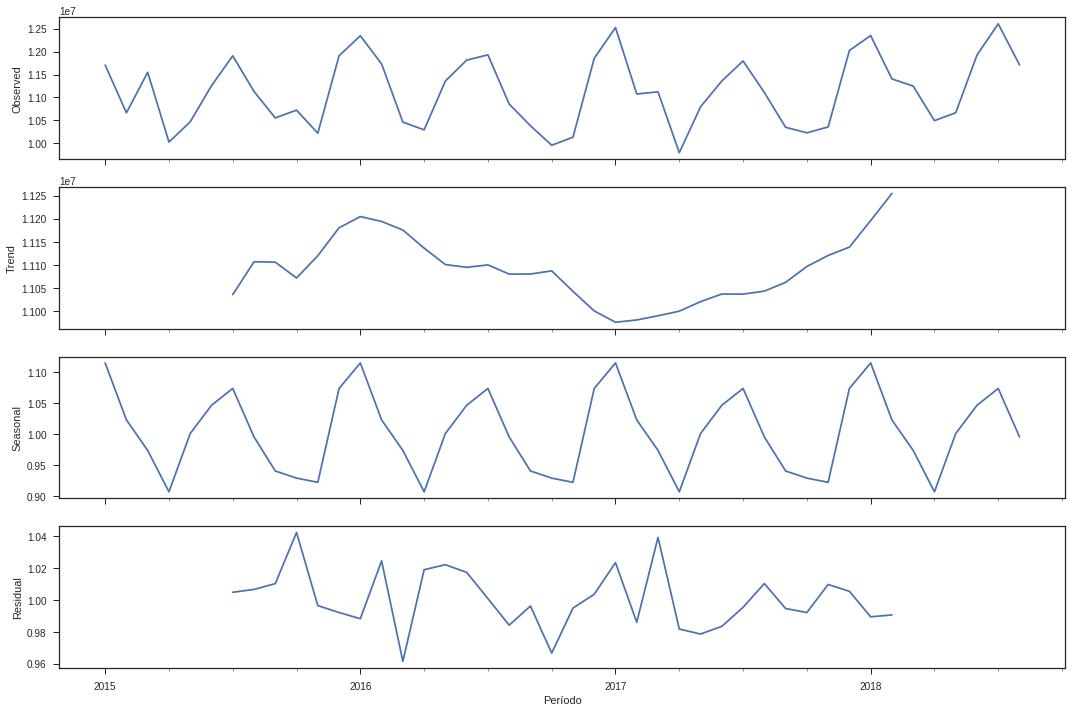

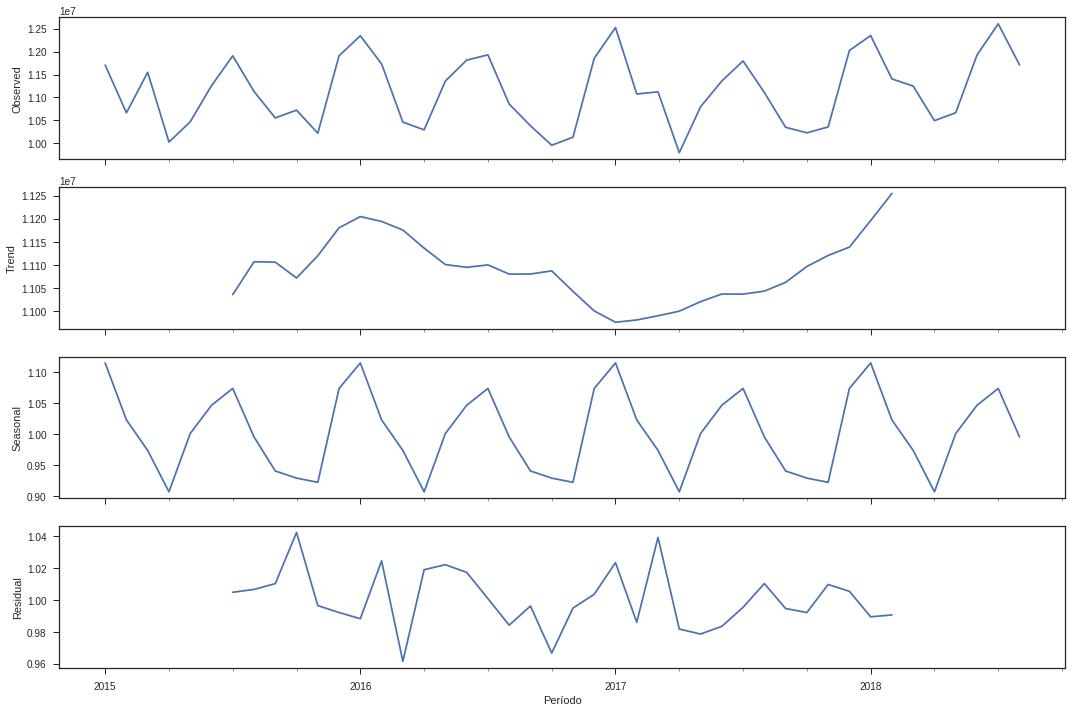

In [17]:
basic_decomposition.plot()

## 2.3 Modelar con Holt y Winter Smoothing
Corresponde al punto 3: Modelar con Holt Winters Smoothing con diferentes parámetros.

### 2.3.1. Aplicación del Método de Holt Smoothing

In [0]:
USAR_DECOMPOSITION_X13 = False


In [0]:
if (USAR_DECOMPOSITION_X13):
    ts = decomposition.seasadj
else:
    ts.index=ts.index.to_period(freq='M')
    

In [20]:

model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

 Smoothing parameter: alpha  1.000
 Smoothing parameter: betha  0.000
 In-sample fit:
 MSE               722496943410.295


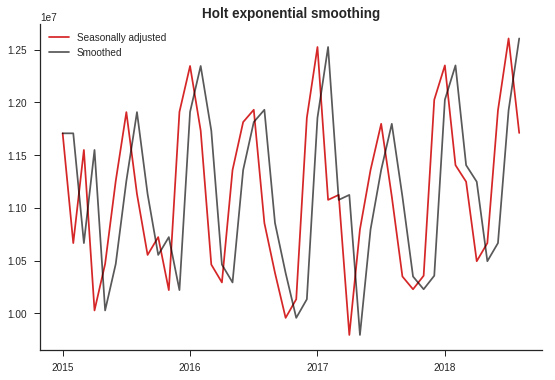

In [21]:
#smoothed=pd.Series(smoothed_sm, index=ts.index)

fig, ax= plt.subplots(figsize=(9,6))

ts['2014':].plot(color='#D62728', label='Seasonally adjusted')
smoothed_sm['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

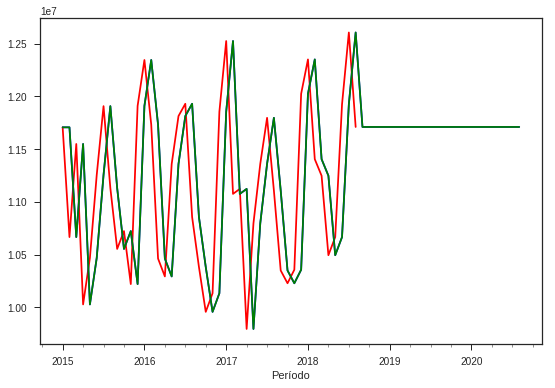

In [22]:
h=24
w=h*3
data = ts
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red',figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

### 2.3.2. Aplicación del Método de Holt-Winter Smoothing

In [0]:
y = ts

In [0]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [0]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [26]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               152389189756.988
 RMSE               390370.580


In [27]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               122864887745.762
 RMSE               350520.881


In [28]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               122864917335.129
 RMSE               350520.923


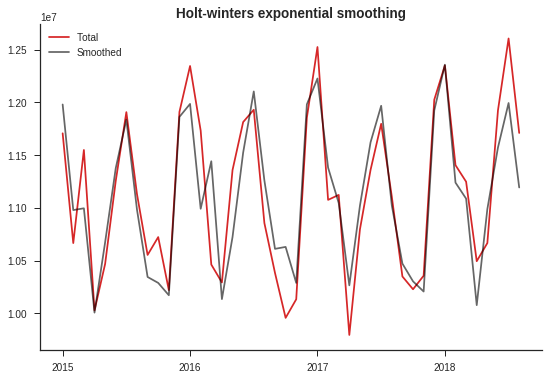

In [29]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots(figsize=(9,6))

y['2015':].plot(color='#D62728', label='Total')
smoothed['2015':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

### 2.3.2.2. Model Diagnostic

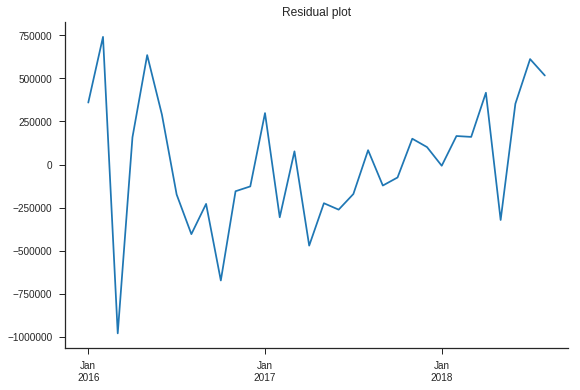

In [30]:
resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

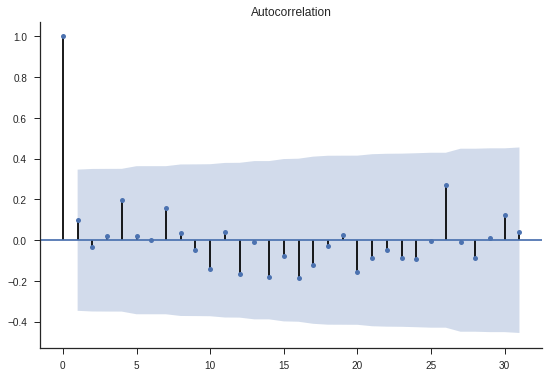

In [31]:
fig, ax = plt.subplots(figsize=(9,6))
lags = len(resid)-1
sm.graphics.tsa.plot_acf(resid, lags=lags, ax=ax)
sns.despine()
plt.show()

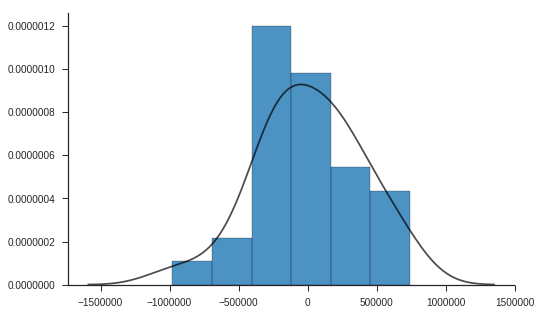

In [32]:
from plotting import histogram
histogram(resid)
plt.show()



## 2.4. Validación de los Modelos

In [33]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2017-09', 'M')

In [0]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [35]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,423432.289,93548.868
Additive,330531.304,85277.147
Multiplicative,326912.546,83119.587


Se observa que para los datos utilizados, el modelo que tiene menor RMSE es el multiplicativo.

## 2.5. Pronóstico

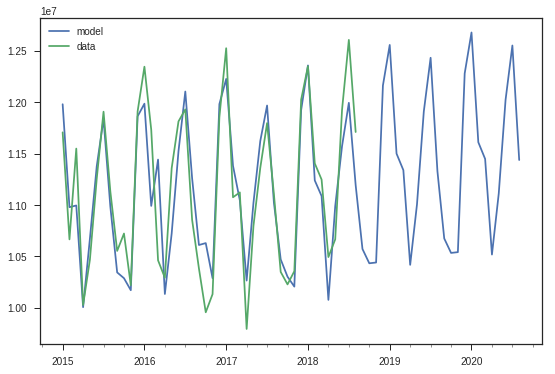

In [36]:
h=24

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = y

plot[:].plot(figsize=(9,6));